In [1]:
import networkx as nx
import torch

from src.archetypes import BiAA, SBM, DBiAA, DSBM
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
k = 3
N = 50
sizes = [N] * k

## Generating a stochastic block model graph

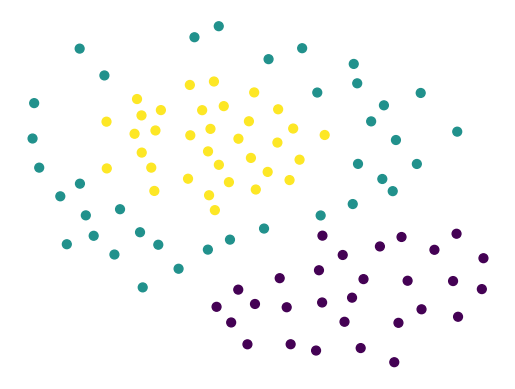

In [3]:
from itertools import chain

np.random.seed(0)
probs = np.random.uniform(0, 1, (3, 3))
probs = torch.tensor(
    [
        [0.9, 0.2, 0.1],
        [0.2, 0.0, 0.7],
        [0.1, 0.7, 0.7]
    ]
)

g = nx.stochastic_block_model(sizes, probs, directed=True)

g_sub = g.subgraph(np.random.choice(N * k, 100, replace=False))
c_sub = np.array(list(chain(*[[i] * N for i in range(k)])))[list(g_sub.nodes)]

pos_sub = nx.spring_layout(g_sub)

nx.draw_networkx_nodes(g_sub, pos_sub, nodelist=g_sub.nodes(), node_color=c_sub, node_size=40)
# nx.draw_networkx_edges(g_sub, pos_sub, alpha=0.05)
plt.axis("off")
plt.show()

In [4]:
a = nx.adjacency_matrix(g)
a = a.astype(np.float32).todense()[np.random.choice(N * k, N * k, replace=False), :][:, np.random.choice(N * k, N * k, replace=False)]
a = torch.tensor(a)

/var/folders/tj/q2qz82qj46qf7mwzd_jqkxnc0000gn/T/ipykernel_4057/1015004702.py:1: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  a = nx.adjacency_matrix(g)


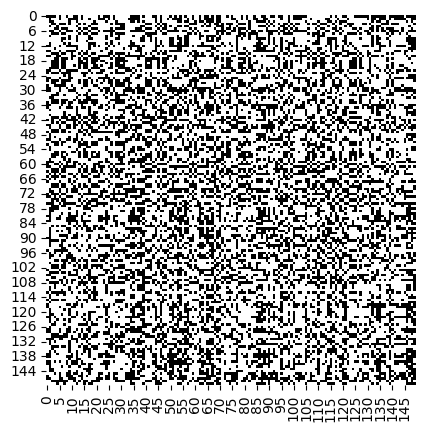

In [5]:
cmap = sns.color_palette("Greys", as_cmap=True)
sns.heatmap(a, cmap=cmap, square=True, cbar=False)
plt.show()

0
1
2
3
4


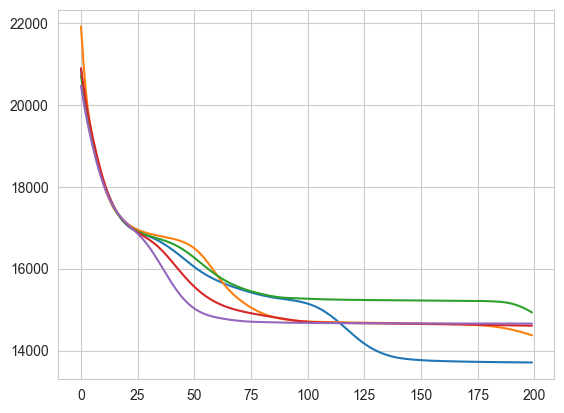

In [27]:
model_sbm = None
for _ in range(5):
    print(_)
    model_i = DSBM((3, 3), a, likelihood="poisson", assignment="soft")
    model_i.fit(200, learning_rate=0.05)
    if not model_sbm or  model_i.losses[-1] < model_sbm.losses[-1]:
        model_sbm = model_i
    plt.plot(model_i.losses)
plt.show()

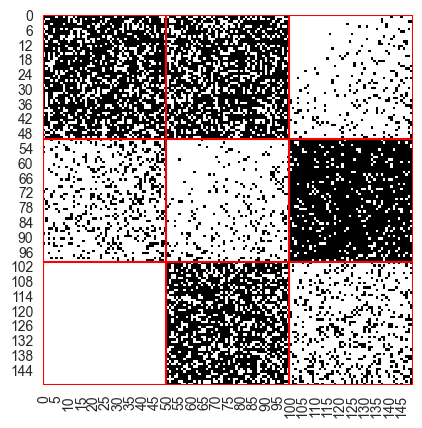

In [28]:
from src.archetypes.visualization.order_data import order_data_hard
order_a, hlines, vlines = order_data_hard(a, model_sbm)

sns.heatmap(order_a, cmap=cmap, square=True, cbar=False)

for hl in hlines:
    pass
    plt.axhline(hl, color="red")
for vl in vlines:
    pass
    plt.axvline(vl, color="red")

plt.show()

Exception ignored in: <function tqdm.__del__ at 0x12c7acf70>
Traceback (most recent call last):
  File "/Users/aleix11alcacer/Projects/pytorch-archetypes/venv/lib/python3.9/site-packages/tqdm/std.py", line 1152, in __del__
  File "/Users/aleix11alcacer/Projects/pytorch-archetypes/venv/lib/python3.9/site-packages/tqdm/notebook.py", line 288, in close
AttributeError: 'tqdm' object has no attribute 'disp'


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

KeyboardInterrupt: 

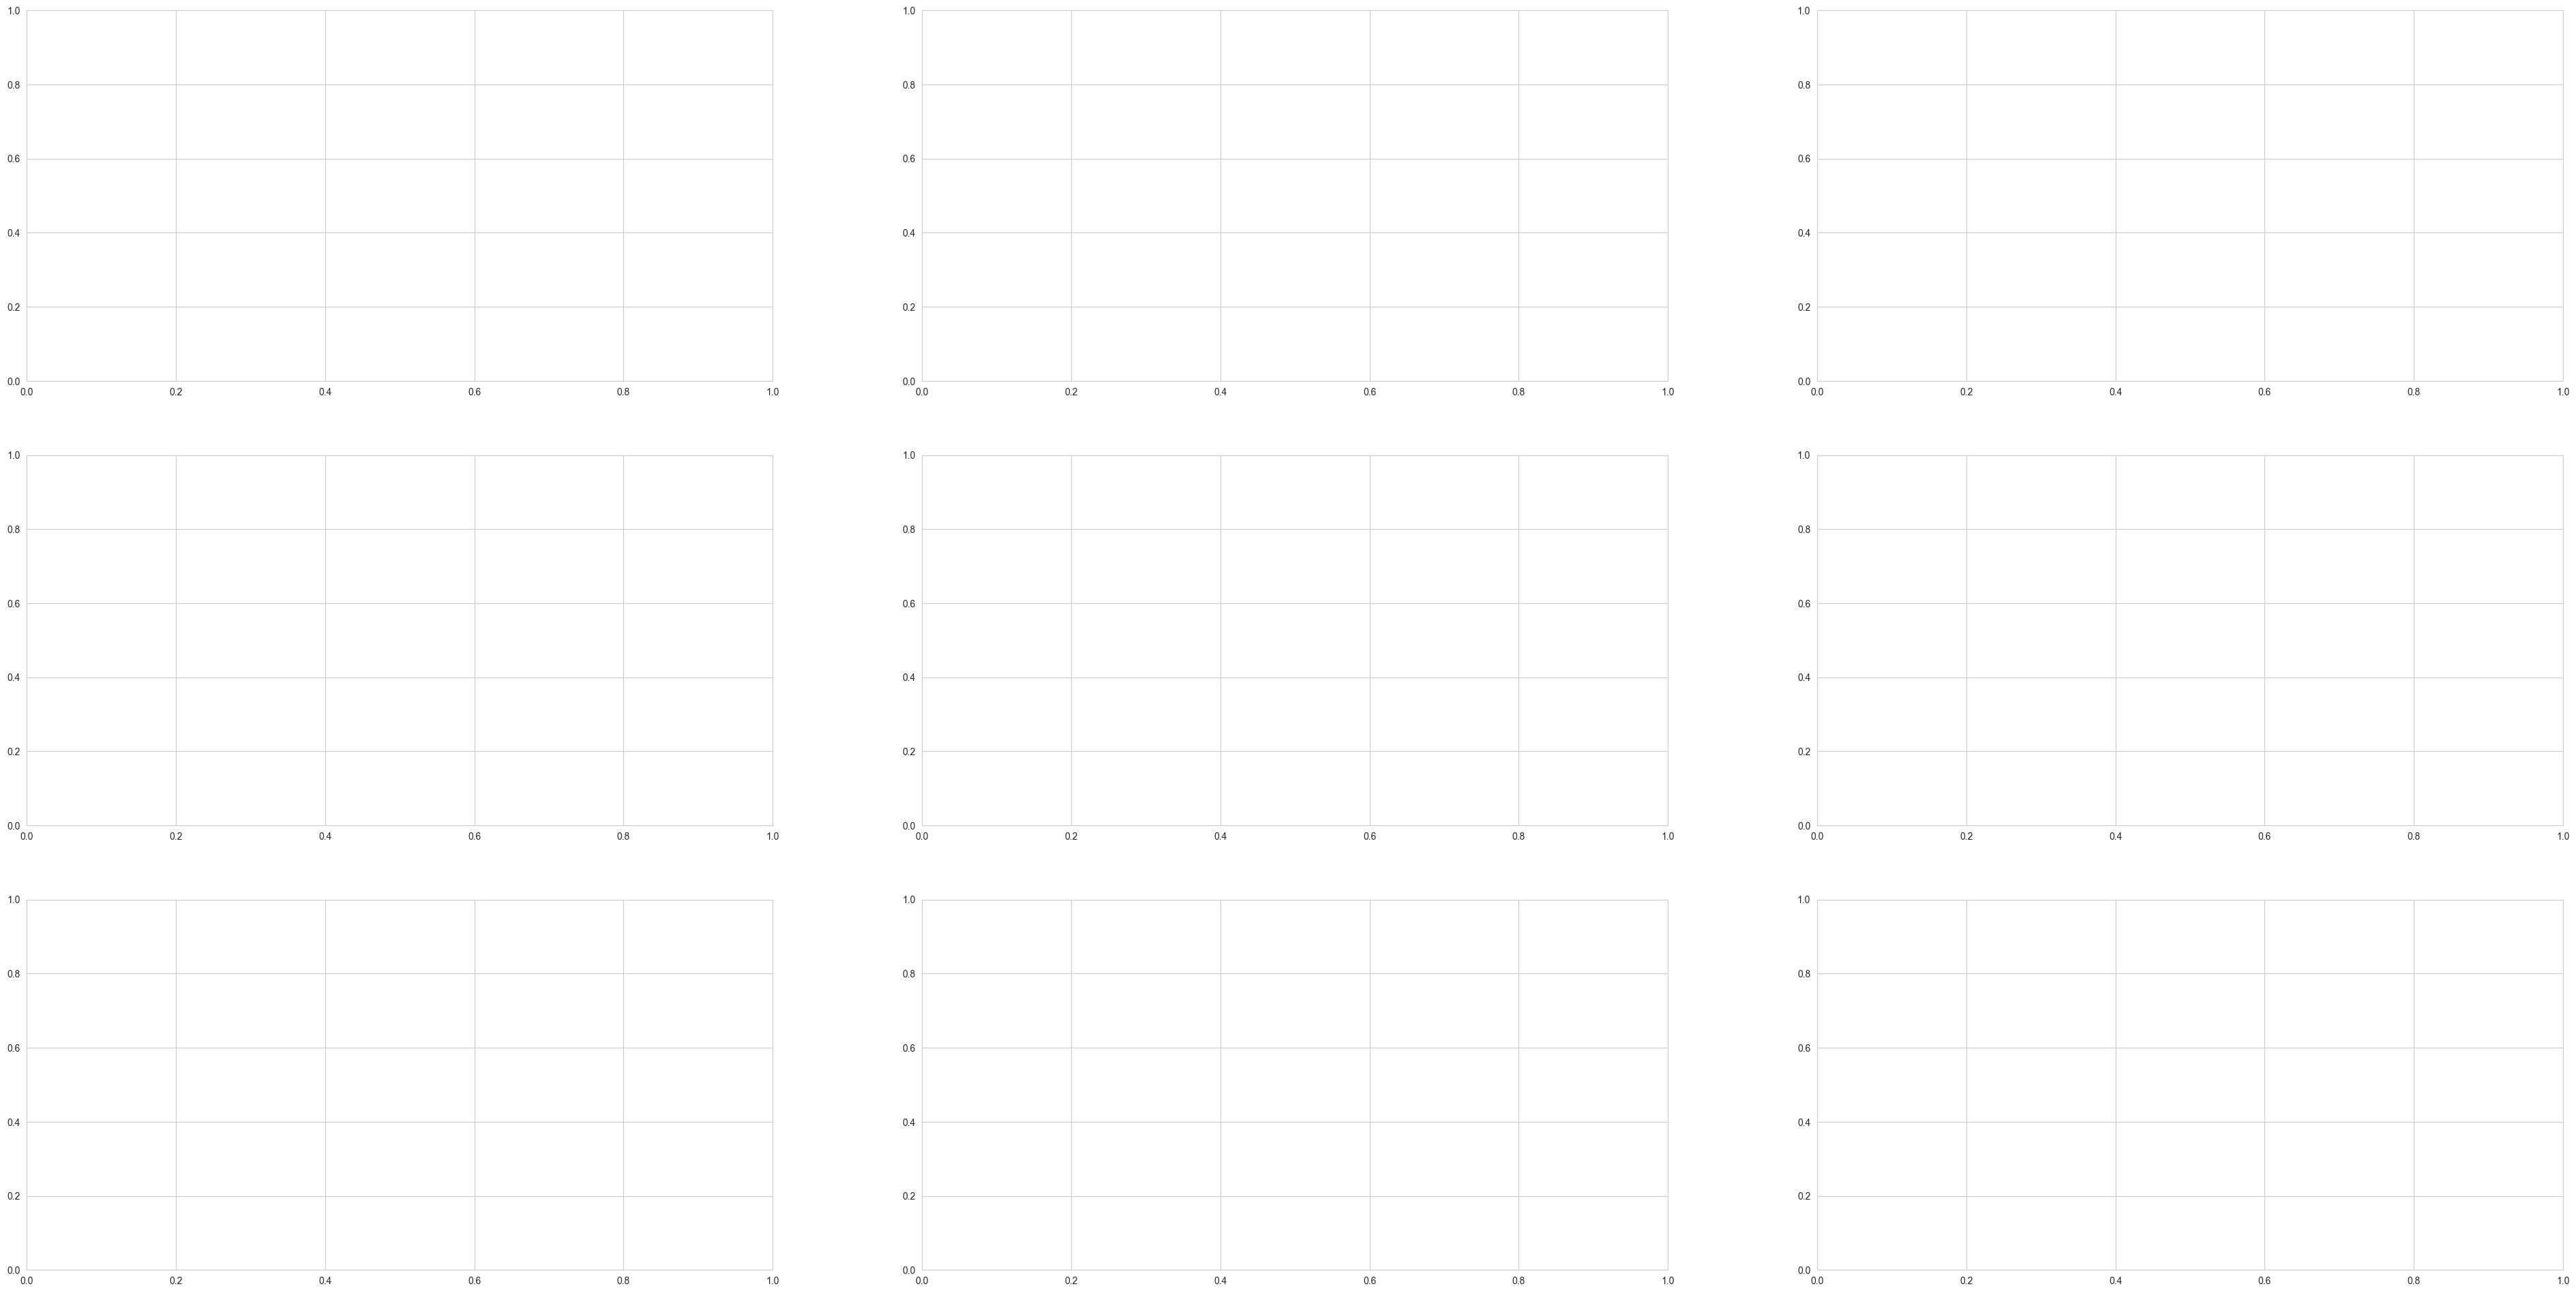

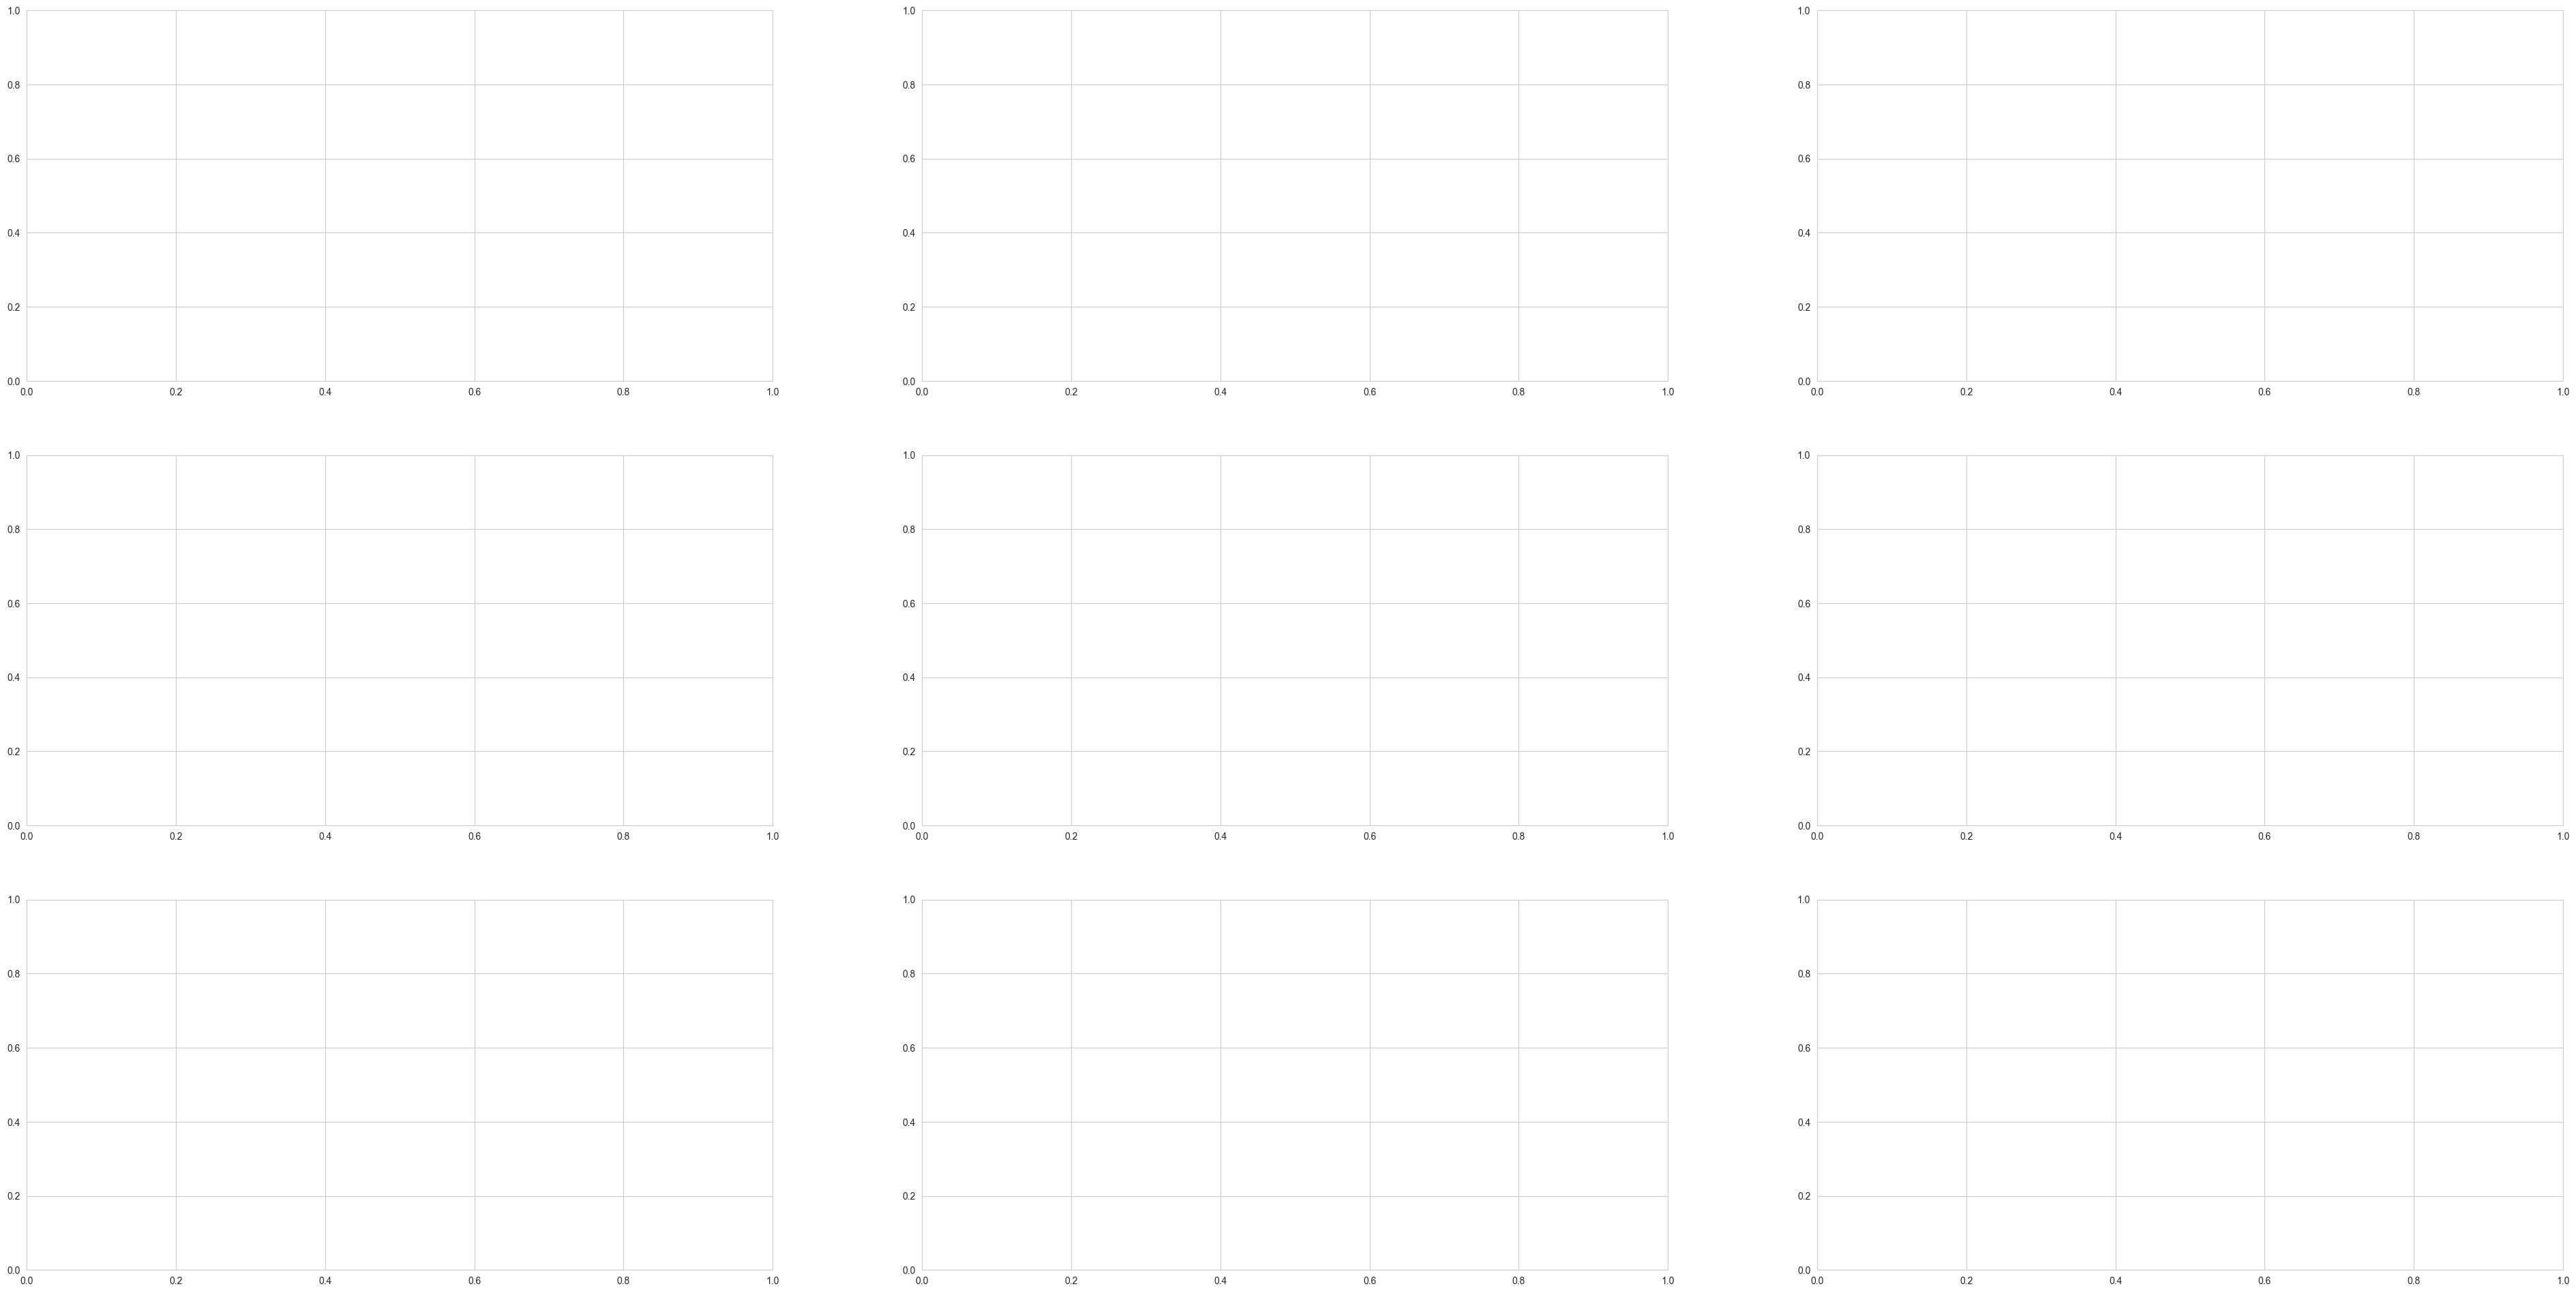

In [63]:
from sklearn.metrics import average_precision_score, roc_auc_score
from tqdm.auto import tqdm
from itertools import product
a_zero = a.clone()
x, y = np.where(a == 1)
i = np.random.choice(len(x), round(len(x) / 10), replace=False)
x_i = x[i]
y_i = y[i]
a_zero[x_i, y_i] = 0
x_zero, y_zero = np.where(a_zero == 0)
y_true = a[x_zero, y_zero].detach().numpy().astype(bool)

k_min, k_max = 2, 11
nrow, ncol = 3, 3
fig_auc, axes_auc = plt.subplots(nrow, ncol, figsize=(ncol * 16, nrow * 8))
fig_prauc, axes_prauc = plt.subplots(nrow, ncol, figsize=(ncol * 16, nrow * 8))
axes_auc = axes_auc.flatten()
axes_prauc = axes_prauc.flatten()

models = [BiAA, SBM, DBiAA, DSBM]
# likelihoods = ["bernoulli"]
assignments = ["soft", "hard"]

auc_min, auc_max = np.inf, -np.inf
prauc_min, prauc_max = np.inf, -np.inf
auc = {}
prauc = {}

for k in tqdm(range(k_min, k_max), leave=True):
    ax_auc = axes_auc[k - k_min]
    ax_prauc = axes_prauc[k - k_min]

    auc_k = {}
    prauc_k = {}
    # for ass, mod, lik in tqdm(list(product(assignments, models, likelihoods)), leave=False):
    for ass, mod in tqdm(list(product(assignments, models)), leave=False):
        key = f"{mod.__name__}\n{ass}"

        for _ in tqdm(range(10), leave=False):
            auc_j = -np.inf
            prauc_j = -np.inf
            for i in tqdm(range(5), leave=False):
                model_i = mod((k, k), a_zero, likelihood="bernoulli", assignment=ass)
                model_i.fit(200, learning_rate=0.05)

                if mod in [BiAA, SBM]:
                    a_rec = model_i.A @ model_i.Z @ model_i.D
                else:
                    a_rec = model_i.a[:, None] * model_i.A @ model_i.Z @ model_i.D * model_i.d[None, :]

                y_score = a_rec[x_zero, y_zero].detach().numpy()

                auc_i = roc_auc_score(y_true, y_score)
                prauc_i = average_precision_score(y_true, y_score)

                if auc_j < auc_i:
                    auc_j = auc_i
                if prauc_j < prauc_i:
                    prauc_j = prauc_i

            auc_k[key] = auc_k.get(key, []) + [auc_j]
            prauc_k[key] = prauc_k.get(key, []) + [prauc_j]
    auc[k] = auc_k
    prauc[k] = prauc_k
    for v in auc_k.values():
            v_min = min(v)
            v_max = max(v)
            if v_min < auc_min:
                auc_min = v_min
            if v_max > auc_max:
                auc_max = v_max

    sns.boxplot(pd.DataFrame(auc_k), ax=ax_auc)
    ax_auc.set_ylabel("ROC-AUC")
    ax_auc.set_xlabel(f"{k} groups")

    for v in prauc_k.values():
        v_min = min(v)
        v_max = max(v)
        if v_min < prauc_min:
            prauc_min = v_min
        if v_max > prauc_max:
            prauc_max = v_max
    sns.boxplot(pd.DataFrame(prauc_k), ax=ax_prauc)
    ax_prauc.set_ylabel("PR-AUC")
    ax_prauc.set_xlabel(f"{k} groups")

auc_thresh = (auc_max - auc_min) * 0.05
for ax in axes_auc:
    ax.set_ylim(auc_min - auc_thresh, auc_max + auc_thresh)

prauc_thresh = (prauc_max - prauc_min) * 0.05
for ax in axes_prauc:
    ax.set_ylim(prauc_min - prauc_thresh, prauc_max + prauc_thresh)

plt.show()

In [6]:
from mmsbm import MMSBM

mmsbm = MMSBM(
    user_groups=3,
    item_groups=4,
    iterations=200,
    sampling=5,
    seed=1,
)

In [8]:
yv, xv = np.meshgrid(range(3 * N), range(3 * N))

X = pd.DataFrame(dict(x=xv.flatten(), y=yv.flatten(), z=a.flatten()))

In [9]:
mmsbm.fit(X)

# theta @

INFO:MMSBM:Running 5 runs of 200 iterations.
100%|██████████| 200/200 [01:09<00:00,  2.86it/s]


In [22]:
r = mmsbm.results[2]

r["theta"] @ r["pr"][..., 1] @ r["eta"].T

array([[7.05579223e-01, 6.78871066e-01, 6.74402428e-01, ...,
        1.30543784e-01, 6.11048386e-01, 8.42614765e-02],
       [8.15908848e-01, 7.03110913e-01, 7.81482526e-01, ...,
        8.14756860e-02, 6.29379635e-01, 2.75416707e-02],
       [3.29051640e-04, 7.82079572e-01, 2.26197799e-03, ...,
        1.58795628e-01, 6.96441698e-01, 1.51957906e-01],
       ...,
       [7.79034761e-01, 6.49614501e-01, 7.43524909e-01, ...,
        1.48061371e-01, 5.87632143e-01, 9.83493626e-02],
       [6.77056251e-01, 6.85769715e-01, 6.47348750e-01, ...,
        1.28674327e-01, 6.16639898e-01, 8.38873972e-02],
       [2.27437438e-01, 2.17893952e-02, 1.83959863e-01, ...,
        9.53489522e-01, 9.84331013e-02, 9.60611325e-01]])

In [62]:
a

tensor([[1., 0., 0.,  ..., 0., 1., 1.],
        [1., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 1.,  ..., 1., 1., 0.],
        ...,
        [1., 1., 0.,  ..., 1., 1., 1.],
        [1., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 1., 1.]])

In [23]:
mmsbm.results

[{'likelihood': array([[ -609.07883854,  -652.4091308 ,  -660.68918697,  -948.91174189],
         [ -396.87330336, -1676.25284452,  -614.99302029,  -634.74574495],
         [ -725.58867147,  -786.09371086,  -653.95474004, -1027.51906965]]),
  'pr': array([[[6.15250981e-05, 9.99938475e-01],
          [9.88544065e-01, 1.14559348e-02],
          [4.85820516e-07, 9.99999514e-01],
          [1.00000000e+00, 9.01338754e-87]],
  
         [[9.99996167e-01, 3.83332547e-06],
          [1.62213158e-13, 1.00000000e+00],
          [8.80652949e-01, 1.19347051e-01],
          [9.99863055e-01, 1.36944764e-04]],
  
         [[5.88848213e-01, 4.11151787e-01],
          [1.00000000e+00, 9.59756836e-11],
          [1.73581252e-01, 8.26418748e-01],
          [2.10739994e-02, 9.78926001e-01]]]),
  'theta': array([[1.59758080e-01, 4.65267059e-02, 7.93715214e-01],
         [7.12192103e-02, 2.08014317e-14, 9.28780790e-01],
         [9.54156147e-01, 4.58438533e-02, 1.41134330e-23],
         [9.40943585e-01, 5.

500